In [10]:

from datasets import load_dataset
from functools import lru_cache
from latex2sympy2_extended import latex2sympy
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sympy import Basic
from sympy.parsing.latex import parse_latex
from transformers import AutoTokenizer, AutoModel
from typing import List, Tuple
import logging
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import random
import re
import sympy
import torch
from collections import Counter

In [37]:
# Set random seed for reproducibility
seed = 42

# Python's built-in random module
random.seed(seed)

# NumPy
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Optional: Reduce verbosity

# Scikit-learn
# No explicit seed setting, but you can pass `random_state=seed` to functions like train_test_split, StratifiedKFold, etc.

# Matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)  # Optional: Consistent colors

In [38]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("zwhe99/DeepMath-103K")

In [86]:
NUM_SAMPLES = 1000

In [87]:
train_ds = ds['train']

In [88]:
random_indices = random.sample(range(len(train_ds['question'])), NUM_SAMPLES if NUM_SAMPLES != float('inf') else len(train_ds['question']))

In [89]:
train_ds_qs = train_ds['question']
train_ds_tp = train_ds['topic']
reason_1_ds = train_ds['r1_solution_1']
reason_2_ds = train_ds['r1_solution_2']
reason_3_ds = train_ds['r1_solution_3']

# Preliminary tasks

## Briefly describe the data

In [21]:
# TODO

## Parsing

### Notes
- [x] Questions have different latex sytanx (`[`, `(`, `$`)
- [x] How do we parse the latex formula?
  - [x] `hybrid-math` with word lenght tokens
  - [x] `tree-walk` where latex qs are transfromed symbolically
- [] How do we tokenize questions?
  - [x] pretrained tokenizers from hf
  - [] https://github.com/google/sentencepiece

In [90]:
train_ds_qs = np.array(train_ds_qs)
train_ds_qs = train_ds_qs[random_indices]

train_ds_tp = np.array(train_ds_tp)
train_ds_tp = train_ds_tp[random_indices]

reason_1_ds = np.array(reason_1_ds)
reason_1_ds = reason_1_ds[random_indices]

reason_2_ds = np.array(reason_2_ds)
reason_2_ds = reason_2_ds[random_indices]

reason_3_ds = np.array(reason_3_ds)
reason_3_ds = reason_3_ds[random_indices]

We remove those with freq < 2 as those will break stratify during train test split

In [91]:
label_counts = Counter(train_ds_tp)
valid_labels = {label for label, count in label_counts.items() if count > 1}

filtered_indices = [i for i, label in enumerate(train_ds_tp) if label in valid_labels]
train_ds_qs = train_ds_qs[filtered_indices]
train_ds_tp = train_ds_tp[filtered_indices]
reason_1_ds = reason_1_ds[filtered_indices]
reason_2_ds = reason_2_ds[filtered_indices]
reason_3_ds = reason_3_ds[filtered_indices]

### Initial investigation on sympy

In [ ]:

def extract_latex_bracket_content(text):
    patterns = [
        r'\\\[(.*?)\\\]',  # \[ ... \]
        r'\\\((.*?)\\\)',  # \( ... \)
        r'\$(.*?)\$',       # $ ... $
    ]
    # Combine patterns into one
    combined_pattern = '|'.join(patterns)
    #matches = [m for m in re.findall(combined_pattern, text, flags=re.DOTALL)]
    #formulas = [next(filter(None, tup)) for tup in matches]
    matches = [m for m in re.findall(combined_pattern, text, flags=re.DOTALL)]
    formulas = []
    for tup in matches:
        non_empty = list(filter(None, tup))
        if non_empty:
            formulas.append(non_empty[0])
    # Use a counter to number the placeholders
    def replacer(match, counter=[1]):
        placeholder = "{" + str(counter[0]-1) + "}"
        counter[0] += 1
        return placeholder
    new_text = re.sub(combined_pattern, replacer, text)
    return new_text, formulas

parsed_indices = []
parsed_text = []
parsed_formulas = []
for i in range(len(train_ds_qs)):
    d = train_ds_qs[i]
    #print("original input:", d)
    text, formulas = extract_latex_bracket_content(d)
    #print("parsed text: ", text, "\nequations: ", formulas)
    formulas_sympy = []
    num_parsed = 0
    for expr in formulas:
        try:
            parsed = parse_latex(expr)
            formulas_sympy.append(parsed)
            num_parsed += 1
        except Exception as e:
            pass
            #print("Could not parse:", e)
            #print(parsed)
    if num_parsed == len(formulas):
        parsed_indices.append(i)
        parsed_text.append(text)
        parsed_formulas.append(formulas_sympy)
print("correctly parsed", len(parsed_indices), "inputs over", len(train_ds_qs))

### Tokenizers

ADD DESCRIPTION

In [92]:
class BaseStrat:
    def __init__(self):
        pass

    def run(self) -> Tuple[bool, List[str]]:
        pass

class TreeWalkStrat(BaseStrat):
    def __init__(self):
        pass

    def run(self, text):
        def print_sympy_tree(expr, indent=0):
            print('  ' * indent + str(expr.func))
            for arg in expr.args:
                print_sympy_tree(arg, indent + 1)

        # --- Parse LaTeX into sympy then walk the expression tree ---
        def flatten_sympy_expr(expr: Basic):
            tokens = []

            def walk(node):
                if isinstance(node, Basic):
                    args_len = len(node.args)
                    args = node.args
                    # If only 1 we build the output as operator + walk(operand)
                    if args_len == 1:
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                        walk(args[0])
                    # If only 2 we build the output with inorder visit walk(operand0) + operator + walk(operand1)
                    elif args_len == 2:
                        walk(args[0])
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                        walk(args[1])
                    # If no operands are found we just add self
                    elif args_len == 0:
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                    # If there are multiple operands (> 2) we add them all after the operator
                    else:
                        if isinstance(node, (sympy.Limit, sympy.Integral)):
                            args = reversed(args)
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                        for arg in args:
                            walk(arg)
                else:
                    raise RuntimeError("not sympy Basic object")

            walk(expr)
            return tokens

        # --- Main tokenization function ---
        def tokenize(text):
            math_pattern = r'(\$\$.*?\$\$|\$.*?\$|\\\[.*?\\\]|\\\(.*?\\\))'
            parts = re.split(math_pattern, text, flags=re.DOTALL)

            final_tokens = []
            is_erorr = False
            for part in parts:
                if re.match(math_pattern, part, flags=re.DOTALL):
                    # Clean math delimiters
                    clean = re.sub(r'^(\$+|\\\[|\\\(|\\])|(\$+|\\\]|\\\))$', '', part.strip())
                    try:
                        parsed = parse_latex(clean)
                        math_tokens = flatten_sympy_expr(parsed)
                        final_tokens.extend(math_tokens)
                    except Exception as e:
                        #is_erorr = True
                        final_tokens.extend(clean.split(' '))
                else:
                    final_tokens.extend(re.findall(r'\b\w+\b', part))
            return is_erorr, final_tokens
        
        return tokenize(text) 

class  HybridMathTokenizerStrat(BaseStrat):
    def __init__(self):
        super().__init__()

    def run(self, text):
        # -----------------------------------------------------------------------------
        #  Regex & cleaning helpers
        # -----------------------------------------------------------------------------
        _MATH_ENV_RE = re.compile(
            r"\$\$(.*?)\$\$"                    # $$...$$
            r"|\\\[(.*?)\\\]"                   # \[...\]
            r"|\\\((.*?)\\\)"                   # \(...\)
            r"|\$(.*?)\$"                           # $...$
            r"|\\begin\{(equation\*?|align\*?|multline)\}(.*?)\\end\{\1\}",
            re.DOTALL,
        )

        _CLEAN_REPLACES = [
            (r"\\displaystyle", ""),
            (r"\\left|\\right", ""),           # sizing commands
            (r"\\[ ,;!]", ""),                 # spacing commands
        ]

        _WORD_RE = re.compile(r"\w+|[^\w\s]", re.UNICODE)


        def clean_latex(latex: str) -> str:
            for pat, rep in _CLEAN_REPLACES:
                latex = re.sub(pat, rep, latex)
            return re.sub(r"\s+", " ", latex).strip()


        def extract_math_spans(text: str) -> Tuple[str, List[str]]:
            spans: List[str] = []
            def _repl(m: re.Match) -> str:
                latex = next(g for g in m.groups() if g is not None)
                idx = len(spans)
                spans.append(latex)
                return f"[[MATH{idx}]]"
            return _MATH_ENV_RE.sub(_repl, text), spans


        def flatten_sympy_expr(expr: sp.Basic) -> List[str]:
            if expr.is_Atom:
                return [str(expr)]
            toks = [expr.func.__name__]
            for arg in expr.args:
                toks.extend(flatten_sympy_expr(arg))
            return toks

        # -----------------------------------------------------------------------------
        #  LaTeX → tokens converter
        # -----------------------------------------------------------------------------
        @lru_cache(maxsize=200_000)
        def tokenize_math(latex: str) -> Tuple[bool, List[str]]:
            latex = clean_latex(latex)
            if len(latex) > 500 or latex.count("{") > 25:
                return False, latex.split()

            try:
                expr = latex2sympy(latex, dummy_symbol_func=lambda n: sp.Symbol(n))
                return False, flatten_sympy_expr(expr)
            except Exception as exc:
                logging.debug("[tokenize_math] fallback on `%s` (%s)", latex, exc)
                # fallback but treat as no error
                return False, latex.split()

        # -----------------------------------------------------------------------------
        #  Plain-text and hybrid tokenizers
        # -----------------------------------------------------------------------------

        def text_tokenize(text: str) -> List[str]:
            return _WORD_RE.findall(text)


        def tokenize(text: str) -> Tuple[bool, List[str]]:
            cleaned, spans = extract_math_spans(text)
            parts = re.split(r"(\[\[MATH\d+\]\])", cleaned)

            tokens: List[str] = []
            had_error = False

            for part in parts:
                m = re.fullmatch(r"\[\[MATH(\d+)\]\]", part)
                if m:
                    idx = int(m.group(1))
                    err, mtoks = tokenize_math(spans[idx])
                    had_error |= err
                    tokens.extend(mtoks)
                    continue
                
                raw = text_tokenize(part)
                i = 0
                while i < len(raw):
                    if raw[i].startswith("\\"):
                        depth = raw[i].count("{") - raw[i].count("}")
                        j = i + 1
                        while j < len(raw) and depth > 0:
                            depth += raw[j].count("{") - raw[j].count("}")
                            j += 1
                        latex_inline = " ".join(raw[i:j])
                        err, mtoks = tokenize_math(latex_inline)
                        had_error |= err
                        tokens.extend(mtoks)
                        i = j
                    else:
                        tokens.append(raw[i])
                        i += 1
            return had_error, tokens
        return tokenize(text) 

class PassThroughStrat(BaseStrat):
    def __init__(self):
        super().__init__()

    def run(self, text):
        return True, [text]

# TODO: add embeddings support
class Tokenizer:
    def __init__(self, strat: str, tokenizer: str):
        self.strat_dict = {
            'tree-walk': TreeWalkStrat,
            'hybrid-math':  HybridMathTokenizerStrat,
            'pass-through': PassThroughStrat
        }
        self.strat = self.strat_dict[strat]()
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer)

    def __call__(self, *args, **kwds):
        parsed = self.parse(*args)
        return self.tokenizer.encode(" ".join(parsed))
    
    def parse(self, *args, **kwds):
        error, res = self.strat.run(*args)
        if error:
            raise RuntimeError(error)
        return res


## Perform cluster analysis on questions field

## Perform cluster analysis on questions field

In [ ]:
# TODO

## Perform document index on different fields

In [ ]:
# pip install -q python-terrier==0.11.0 #now there is another version but we don't use it

In [ ]:
import os
os.environ["JAVA_HOME"] = "/opt/homebrew/Cellar/openjdk@11/11.0.21/libexec/openjdk.jdk/Contents/Home"
os.environ["JVM_PATH"] = "/opt/homebrew/Cellar/openjdk@11/11.0.26/libexec/openjdk.jdk/Contents/Home/lib/server/libjvm.dylib"

In [ ]:
column_names = train_ds.column_names
print(column_names)

# 2. Initialize PyTerrier (only once)
import pyterrier as pt

# google colab
#if not pt.started():
#  pt.init()

# vs code in mac
if not pt.java.started():
    pt.init()

### Finding "quadratic form" in 'question'

In [ ]:
# 3. Build a corpus iterator over the 'question' field
def get_question_corpus(ds):
    for i, example in enumerate(ds):
        yield {
            'docno': str(i),                          # unique document ID
            'question': example['question']           # only the question text
        }

# 4. Index into a new folder, specifying that we only want the 'question' field
pt_index_path = './terrier_deepmath_questions'
indexer = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref = indexer.index(
    get_question_corpus(train_ds),
    fields=('question',),
    meta=('docno', 'question')  # store docno + question in the metadata
)

# 5. Load the index and run a TF-IDF retrieval over the 'question' field
index = pt.IndexFactory.of(index_ref)
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
results = tfidf.search("quadratic form")
print(results.head(6))

### Perform a 'question' search in only documents with x difficulty

In [ ]:
# Imposto difficulty = 0.0
filtered_ds = [ex for ex in train_ds if float(ex['difficulty']) == 0.0]

# Build a corpus iterator over the 'question' field
def get_question_corpus(ds):
    for i, example in enumerate(ds):
        yield {
            'docno': str(i),                          # unique document ID
            'question': example['question']           # only the question text
        }

# Index into a new folder, specifying that we only want the 'question' field
pt_index_path = './terrier_deepmath_questions'
indexer = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref = indexer.index(
    get_question_corpus(filtered_ds),
    fields=('question',),
    meta=('docno', 'question')
)

# Load the index and run a TF-IDF retrieval over the 'question' field
index = pt.IndexFactory.of(index_ref)
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
query = "quadratic form"
query1 = "quadratic form optimization minimize" #puoi mettere piu parole e funziona
results = tfidf.search(query)
print(results.head(6))

### Finding 'quadratic form' in more fields (NON RIUSCITO)

## Generate embeddings and analyze them

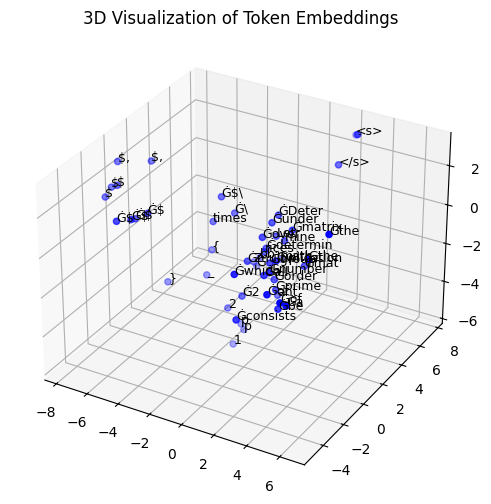

In [ ]:
# TODO: fix! clusterize whole sentences

# Example token IDs (replace with your token IDs)
token_id = token_ids[45]

model = AutoModel.from_pretrained(model_name)

# Convert token IDs to embeddings
input_ids = torch.tensor([token_id])  # Add batch dimension
with torch.no_grad():
    outputs = model(input_ids)
    embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: (seq_len, hidden_dim)

# Reduce dimensions to 3D using PCA
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

# Visualize in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c='blue', marker='o')

# Annotate tokens
tokens = tokenizer.convert_ids_to_tokens(token_id)
for i, token in enumerate(tokens):
    ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], token, fontsize=9)

ax.set_title("3D Visualization of Token Embeddings")
plt.show()

# Training

## M1C: Base model (topic classification)

initial investigation on which classification method works better for this dataset

In [ ]:
# TODO: investigate different tokenizers and fitting performance
# TODO: research if max iter matters (from litterature)
# TODO: try step by step classification (from outer to inner)

fitted: LinearSVC(max_iter=10000)
fitted: SGDClassifier(class_weight='balanced', max_iter=10000)
fitted: SGDClassifier(class_weight='balanced', loss='log_loss', max_iter=10000)
fitted: LogisticRegression(max_iter=1000, n_jobs=-1)
fitted: MultinomialNB()


,model,accuracy,macro_f1
1,SGD-hinge,0.412060,0.330846
0,LinearSVC,0.442211,0.308588
2,SGD-log,0.427136,0.285680
3,LogisticRegression,0.346734,0.124952
4,MultinomialNB,0.170854,0.047981


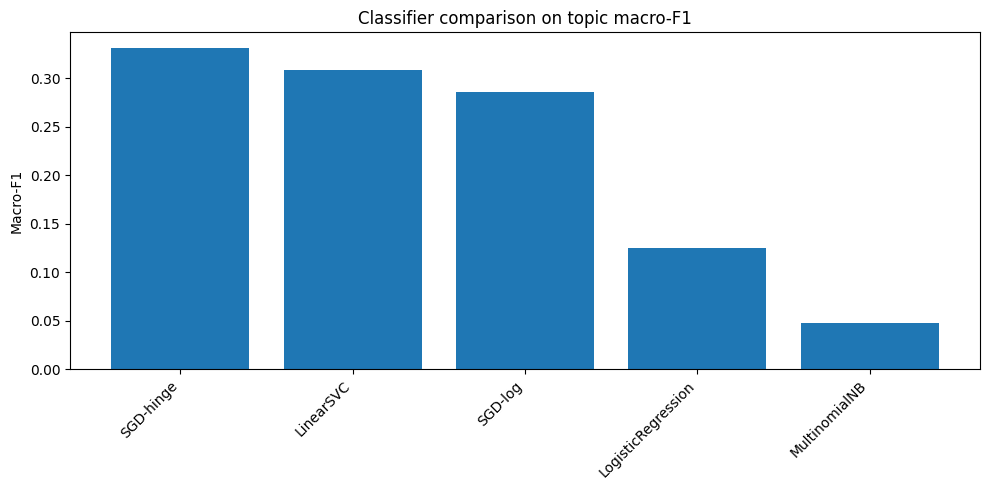

Best model: SGD-hinge
Accuracy: 0.4120603015075377
Macro-F1: 0.33084569782444273
Best model class: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>


In [93]:
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    train_ds_qs, train_ds_tp,
    test_size=0.2, random_state=seed,
    stratify=train_ds_tp
)

# 2. Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw)

counts = Counter(y_train)
total = len(y_train)

# Inverse‐frequency weights
weights = {cls: total/(len(counts)*cnt) for cls, cnt in counts.items()}

# 3. Select tokenizer
tokenizer = Tokenizer('tree-walk', "allenai/longformer-base-4096")

# 4. Define a suite of classifiers to compare
classifiers = {
    "LinearSVC":             LinearSVC(max_iter=10000),
    "SGD-hinge":             SGDClassifier(loss="hinge", class_weight="balanced", max_iter=10000),
    "SGD-log":               SGDClassifier(loss="log_loss",  class_weight="balanced", max_iter=10000),
    "LogisticRegression":    LogisticRegression(max_iter=1000, n_jobs=-1),
    "MultinomialNB":         MultinomialNB(),
}

classifiers_classes = {
    "LinearSVC":             LinearSVC,
    "SGD-hinge":             SGDClassifier,
    "SGD-log":               SGDClassifier,
    "LogisticRegression":    LogisticRegression,
    "MultinomialNB":         MultinomialNB,
}

vectorizer =  TfidfVectorizer(
    tokenizer=tokenizer.parse,
    lowercase=True,
    token_pattern=None
)
X_train_vectorized =  vectorizer.fit_transform(X_train)
X_test_vectorized =  vectorizer.transform(X_test)

# 5. Train, predict, record metrics
results = []
for name, clf in classifiers.items():
    clf.fit(X_train_vectorized, y_train)
    print("fitted:",clf)
    yp = clf.predict(X_test_vectorized)
    results.append({
        "model":    name,
        "accuracy": accuracy_score(y_test, yp),
        "macro_f1": f1_score(y_test, yp, average="macro")
    })

df = pd.DataFrame(results).sort_values("macro_f1", ascending=False)
display(df)

# 6. Plot macro-F1 for easy comparison
plt.figure(figsize=(10,5))
plt.bar(df["model"], df["macro_f1"])
plt.ylabel("Macro-F1")
plt.xticks(rotation=45, ha="right")
plt.title("Classifier comparison on topic macro-F1")
plt.tight_layout()
plt.show()

# Find the best model based on macro_f1
best_result = max(results, key=lambda x: x["macro_f1"])
best_model_name = best_result["model"]

print(f"Best model: {best_model_name}")
print(f"Accuracy: {best_result['accuracy']}")
print(f"Macro-F1: {best_result['macro_f1']}")

# Retrieve the corresponding classifier from the classifiers dictionary
best_model_class = classifiers_classes[best_model_name]
print(f"Best model class: {best_model_class}")



Tune the best model with optuna

In [94]:
X       = train_ds_qs
y_raw   = train_ds_tp
le      = LabelEncoder()
y       = le.fit_transform(y_raw)

N_TRIALS = 5

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

from collections import Counter
counts = Counter(y_train)
total  = len(y_train)
n_cls  = len(counts)
weights = {
    cls : total/(n_cls * count)
    for cls, count in counts.items()
}

def objective(trial):
    # TF–IDF params
    ngram_min    = trial.suggest_int("ngram_min", 1, 2)
    ngram_max    = trial.suggest_int("ngram_max", ngram_min, 3)
    max_df       = trial.suggest_float("max_df", 0.5, 1.0)
    min_df       = trial.suggest_int("min_df", 1, 5)
    #max_features = int(trial.suggest_int("max_features", 10_000, 50_000, step=5_000))

    max_iter = 10000
    if best_model_name == "LinearSVC":
        C            = trial.suggest_float("C", 1e-4, 1e2, log=True)
        weight_choice = trial.suggest_categorical("weight_choice", ["none", "custom"])
        if weight_choice == "none":
            class_weight = None
        else:
            class_weight = weights
        loss         = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
        dual         = True if loss == "hinge" else False
        model = best_model_class(
            C,
            class_weight=class_weight,
            loss=loss,
            dual=dual,
            max_iter=max_iter,
            random_state=seed
        ) 
    elif best_model_name in ["SGD-hinge", "SGD-log"]:
        loss         = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
        weight_choice = trial.suggest_categorical("weight_choice", ["none", "custom"])
        if weight_choice == "none":
            class_weight = None
        else:
            class_weight = weights
        model = best_model_class(
            class_weight=class_weight,
            loss=loss,
            max_iter=max_iter,
            random_state=seed
        ) 
    elif best_model_name == "LogisticRegression":
        model = best_model_class(
            max_iter=max_iter,
            n_jobs = 1
        ) 
    elif best_model_name == "MultinomialNB":
        model = best_model_class(
        ) 
    else:
        raise RuntimeError('not impl')


    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(
             tokenizer=tokenizer.parse,
             lowercase=True,
             token_pattern=None,
             ngram_range=(ngram_min, ngram_max),
             max_df=max_df,
             min_df=min_df,
             #max_features=max_features,
        )),
        ("clf", model)
    ])

    
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    scorer = make_scorer(f1_score, average="macro")

    scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=cv, scoring=scorer, n_jobs=1
    )
    return scores.mean()

study = optuna.create_study(direction="maximize", study_name=f"{best_model_name}_tuning")
study.optimize(objective, n_trials=N_TRIALS, timeout=3600)

best_macro_f1 = study.best_value
best_params = study.best_params

print("Best macro-F1:", study.best_value)
print("Best hyperparameters:", study.best_params)

Best macro-F1: 0.17593021108708679
Best hyperparameters: {'ngram_min': 1, 'ngram_max': 2, 'max_df': 0.87356315058997, 'min_df': 3, 'loss': 'hinge', 'weight_choice': 'custom'}


Best macro-F1: 0.22819337166898143
Best hyperparameters: {'ngram_min': 1, 'ngram_max': 2, 'max_df': 0.7832138168654517, 'min_df': 1, 'C': 44.281459120039905, 'weight_choice': 'none', 'loss': 'hinge'}

l'ets fit the model with the found params

In [95]:
X = train_ds_qs
y_raw = train_ds_tp

X_train, X_test, y_train, y_test = train_test_split(
    X, y_raw, test_size=0.2, random_state=42,
	stratify=y_raw
)

le = LabelEncoder()
y = le.fit_transform(y_raw)

def build_model(model_name):
    max_iter = 10000
    if model_name == "LinearSVC":
        model = best_model_class(
            best_params['C'],
            class_weight=None,
            loss=best_params['loss'],
            max_iter=max_iter,
            random_state=seed
        ) 
    elif model_name in ["SGD-hinge", "SGD-log"]:
        model = best_model_class(
            class_weight=None,
            loss=best_params['loss'],
            max_iter=max_iter,
            random_state=seed
        ) 
    elif model_name == "LogisticRegression":
        model = best_model_class(
            max_iter=max_iter,
            n_jobs = 1
        ) 
    elif model_name == "MultinomialNB":
        model = best_model_class(
        ) 
    else:
        raise RuntimeError('not impl')
    return model

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        tokenizer=tokenizer.parse,
        lowercase=True,
        token_pattern=None, ngram_range=(best_params['ngram_min'], best_params['ngram_max']), max_df=best_params['max_df'], min_df=best_params['min_df']
    )),
    ("clf", build_model(best_model_name))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.37185929648241206

Classification report:

                                                                                                     precision    recall  f1-score   support

                                         Mathematics -> Algebra -> Abstract Algebra -> Field Theory       0.33      0.25      0.29         4
                                         Mathematics -> Algebra -> Abstract Algebra -> Group Theory       0.55      0.75      0.63         8
                                                Mathematics -> Algebra -> Abstract Algebra -> Other       0.00      0.00      0.00         3
                                          Mathematics -> Algebra -> Abstract Algebra -> Ring Theory       0.50      0.75      0.60         4
                                         Mathematics -> Algebra -> Algebra -> Algebraic Expressions       0.50      0.50      0.50         2
                                    Mathematics -> Algebra -> Algebra -> Equations and Inequalitie

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

## M1R: Base model (difficulty regression)

## M1S: Base model (short answer)

## M2: Introduce reasoning

## Comparisons